# NPR MC1 RAG

Authors:
- Michelle Roherer
- Léonie Bécheiraz
- Sabina Gruener

## Kurzbeschreibung:



## Sources:

Für das jupyter-book wird folgender Befehl im Terminal ausgeführt jupyter-book build MC1/doc/npr_mc1_jupyter-book/ --quiet

## EDA



### Daten kennen lernen

Um den Datensatz kennen zu lernen und dabei die verschiedenen Technologien im Zusammenhang mit textuellen Daten und Modellen zu verstehen, werden wir verschiedene Pakete anwenden.

Inhalt:
- `langdetect`
- `Counter`
- `TextCleaner`
- `WordCloud`

### Libraries  

Falls mit einer `venv` gearbeitet wird, muss die `venv` aktiviert sein. Dies kann über den Befehl `venv\\Scripts\\activate` ausgeführt werden.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import langdetect
import re

from collections import Counter
from collections import OrderedDict
from langdetect import detect

import torch

import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath("../"))
import src.utilities as u
import src.plots as p
import src.constants as c
c_stopwords = c.custom_stopwords

from src.utilities import TextCleaner
from src.credentials import AZURE_OPENAI_API_KEY, AZURE_OPENAI_ENDPOINT
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

#!pip install langchain-community
#!pip install openai
#!pip install tiktoken

### Daten Laden

Die Daten, welche wir aus einer `.csv` Datei laden, welche von einer Website stammen. Mit diesen Daten möchten wir später unsere Fragen beantworten.

#### Datenbeschreibung
- **id** Unique ID des Artikels
- **title** Title des Artikels
- **date** Erscheinungsdatum des Artikels
- **author** Name des Autors
- **content** Inhalt des Artikels
- **domain** von wo der Artikel kommt
- **url** Webadresse (wie man den Artikel finden kann)

In [2]:
file_path = "../data_mc1/"
file_name_train = 'cleantech_media_dataset_v3_2024-10-28.csv'
# full_path = os.path.join(file_path, file_name_train)

column_names = ["id", "title", "date", "author", "content", "domain", "url"]
# df_train = pd.read_csv(full_path, delimiter=",", names=column_names, skiprows=1, encoding="utf-8")
df_train = pd.read_csv(file_path+file_name_train, delimiter=",", names=column_names, skiprows=1, encoding="utf-8")

In [3]:
df_train.head()

,id,title,date,author,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,NaN,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,NaN,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,NaN,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...


In [4]:
# print(df_train.columns)

In [5]:
u.missing_value_stats(df_train)

,NaN/None (%),0-Werte (%)
id,0.0,0.0
title,0.0,0.0
date,0.0,0.0
author,100.0,0.0
content,0.0,0.0
domain,0.0,0.0
url,0.0,0.0


Der Spalte **author ist vollständig fehlend**, nach Ansehen des Artikels ist schnell ersichtlich, dass dieser über Webscraping aus den Artikeln extrahiert werden könnte. Da aber in den Evaluierungsdaten keine Frage bezüglich des Authors vorhanden ist wird diese nun entfernt. Allerdings könnte diese Information Wert liefern im Bezug auf Ähnlichkeitsberechnung von Inhalten der Artikeln, dies könnte später erneut überprüft werden. **Vorerst wird die Spalte author erntfernt.**

In [6]:
df_train = df_train.drop(columns=["author"])

In [7]:
df_train.dtypes

id          int64
title      object
date       object
content    object
domain     object
url        object
dtype: object

Nachdem die offensichtlichen Bereinigungen vorgenommen wurden, möchten wir einen Überblick über wichtigsten Metriken. 

Dabei werden die Objekt-Spalten in folgenden Kategorien angezeigt:

- `count`: Anzahl der nicht-leeren Werte

- `unique`: Anzahl der einzigartigen Werte

- `top`: Der am häufigsten vorkommende Wert

- `freq`: Die Häufigkeit dieses Wertes

Wir fügen den Zeilenumbruch für die Ausgabe ein, damit der gesamte Text sichtbar wird.

In [8]:
# styled = df_train.describe(include=[object]).style.set_properties(**{
#     'white-space': 'pre-wrap',     # erlaubt Zeilenumbrüche
#     'word-wrap': 'break-word',     # bricht bei Wortgrenzen
# })
# styled

In [9]:
# from IPython.display import display
# 
# display(styled)

In [10]:
# styled = (
#     df_train.describe(include=[object])
#     .applymap(u.shorten_text)  # auf alle Zellen anwenden
#     .style
#     .set_properties(**{
#         'white-space': 'pre-wrap',    # \n sichtbar
#         'max-width': '300px',         # Zellbreite beschränken
#         'font-family': 'monospace',   # bessere Darstellung
#     })
# )

# styled

u.styled_text(df_train.describe(include=[object]))

,title,date,content,domain,url
count,20111,20111,20111,20111,20111
unique,20016,979,20068,25,20111
top,About David J. Cross,2023-06-13,"[""By the end of 2022, 37% of single-family homes a cross the five islands Hawaiian Electric serves ha d rooftop solar, Oahu's first grid-scale solar and storage project was online, and the state's last remaining coal plant was retired. That's the kind ...",energy-xprt,https://www.pv-magazine.com/2024/10/24/kaust-helmh oltz-zentrum-berlin-present-31-2-efficient-blade-c oated-perovskite-silicon-tandem-solar-cell/#respon d
freq,13,1812,3,4181,1


Wir sehen nun, dass:
- **Total Reihen** es sind 20111 Reihen vorhanden
- **title** die meisten Artikel haben ihren eigenen Titel 
- **date** es sind nur 979 Datum vorhanden, was im Umkehrschluss bedeutet, dass mehrere Artikel das gleiche Datum tragen
- **content** es sind mehr einzigartige Artikel vorhanden als Titel. Die Einzigartigkeit könnte auch mit der Darstellung der Website zusammen hängen. Daher kann es sein, dass nach der Bereinigung des Textes mehrere Artikel gleich sind als jetzt.
- **domain** es gibt nur 25 verschiedene Domains was wiederum bedeutet, dass diese Domains sehr viele Artikel enthalten
- **url** jede Zeile stammt von einer anderen url.
- **top** diese Information sagt uns welcher Titel (About David J. Cross), Artikel, welche Domain (enery-xprt), url oder welches Datum (13.08.2023) am häufigsten vorkommt und somit wo und wie wir nach dieser Häufigkeit suchen müssen

In [11]:
# df_train.describe(include=[object])

**Anpassen der Datentypen**  

id: int64 -> bleibt int64  
title: object -> string  
date: object -> datetime  
content: object -> string  
domain: object -> string  
url: object -> string  

Datumsformat erstellen

In [12]:
# Datentypen korrigieren
df_train["date"] = pd.to_datetime(df_train["date"], errors="coerce")  # Falls ungültige Datumswerte vorhanden
# df_train["title"] = df_train["title"].astype(str)
# df_train["content"] = df_train["content"].astype(str)

In [13]:
df_train.dtypes

id                  int64
title              object
date       datetime64[ns]
content            object
domain             object
url                object
dtype: object

### Untersuchen der ersten Erkenntnisse
Die ersten Erkenntnisse möchten wir nun genauer unter die Lupe nehmen und einige Analysen über die Top-Werte erstellen.

#### Artikel pro Domain

Als erstes werden wir schauen, wieviele Artikel pro Domain vorhanden sind. Dazu zählen wir die Artikel pro Domain.

In [14]:
articles_per_domain = df_train.groupby("domain").size().reset_index(name="count")
articles_per_domain = articles_per_domain.sort_values(by="count", ascending=False)
articles_per_domain.reset_index(drop=True, inplace=True)

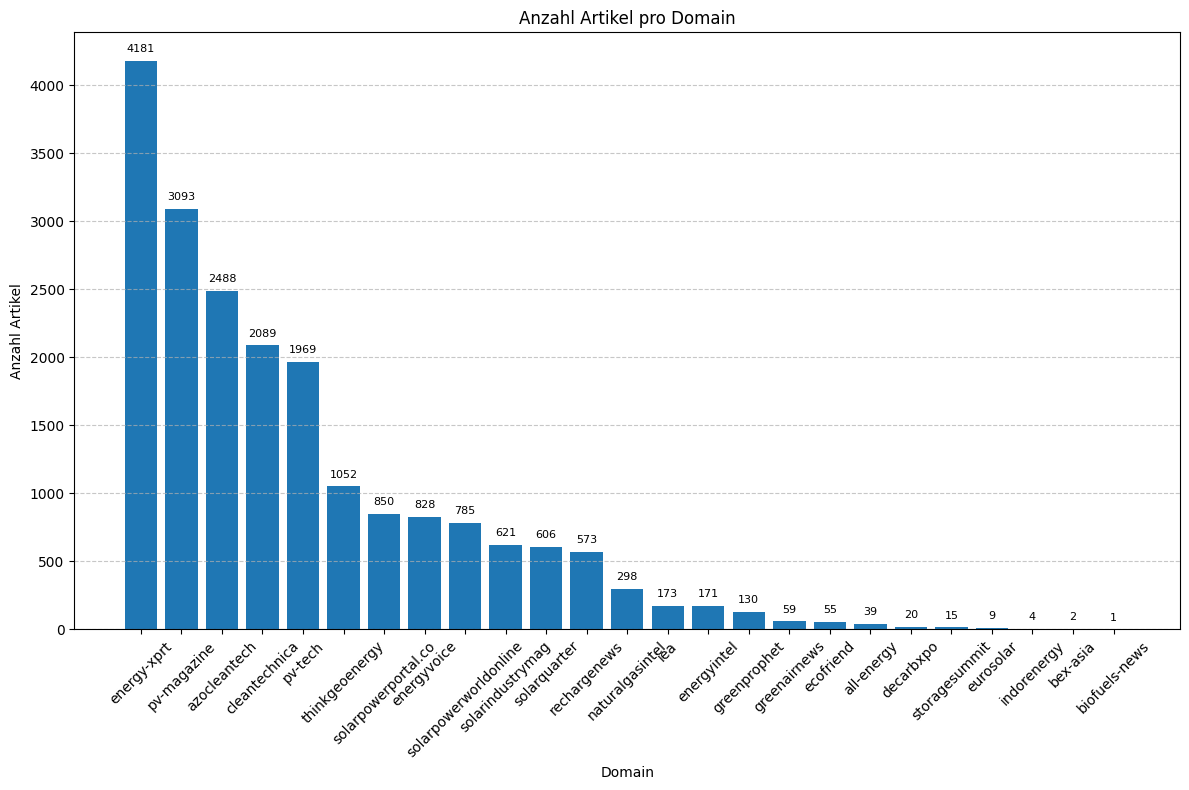

In [15]:
p.bar_plot(articles_per_domain, "domain", "count", "Anzahl Artikel pro Domain", "Domain", "Anzahl Artikel", xrotation=45)

NEXT: Erkenntnisse aus dem vorherigen Code

#### Anzahl Artikel zu Top-Titel

In [16]:
articles_per_title_top_15 = df_train.groupby("title").size().reset_index(name="count")
articles_per_title_top_15 = articles_per_title_top_15.sort_values(by="count", ascending=False).head(15)
articles_per_title_top_15.reset_index(drop=True, inplace=True)

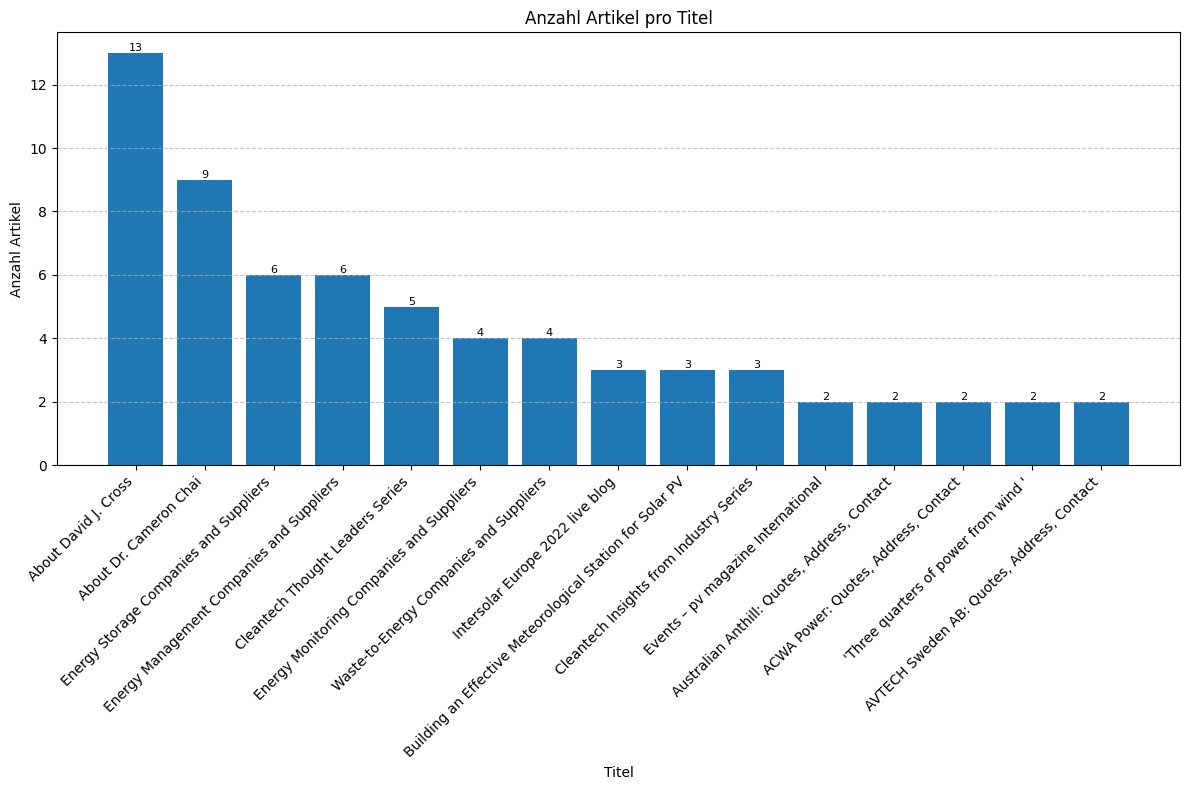

In [17]:
p.bar_plot(articles_per_title_top_15, "title", "count", "Anzahl Artikel pro Titel", "Titel", "Anzahl Artikel", xrotation=45, ha_xrotation='right', height_offset=0)

#### Anzahl pro Domain mit dem Titel 'About David J. Cross'
Ob verschiedene Domains Artikel mit dem Titel 'About David J. Cross' veröffentlicht haben möchten wir hier untersuchen.

In [18]:
article_count_per_title = df_train[df_train["title"] == "About David J. Cross"].groupby("domain").size().reset_index(name="count")
article_count_per_title = article_count_per_title.sort_values(by="count", ascending=False)
article_count_per_title.reset_index(drop=True, inplace=True)
article_count_per_title

,domain,count
0,azocleantech,13


Es nur eine Domain, die alle Veröffentlichungen zu diesem Titel gemacht hta. Die "normale" Duplikatensuche keine Ergebnisse lieferte, könnte es sein, dass es sich hier um kleinere Unterschiede beim Inhalt (updates), unterschiedliche Veröffentlichungs-Daten oder verschiedene URLs handeln. Dies wollen wir genauer untersuchen.

In [19]:
article_count_per_title = df_train[df_train["title"] == "About David J. Cross"]
u.styled_text(article_count_per_title)

,id,title,date,content,domain,url
1721,21198,About David J. Cross,2022-05-26 00:00:00,"['We use cookies to enhance your experience. By co ntinuing to browse this site you agree to our use of cookies. More info.', 'B.A ( Hons) Comparative Literary Studies, M.A. Modern Cultures', 'David is an academic researcher and interdisciplinary arti ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=6
6940,22486,About David J. Cross,2023-05-04 00:00:00,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=4
6941,22487,About David J. Cross,2023-05-04 00:00:00,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=2
6942,22488,About David J. Cross,2023-05-04 00:00:00,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=11
7107,22482,About David J. Cross,2023-05-04 00:00:00,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...",azocleantech,https://www.azocleantech.com/authors/david-cross
7110,22485,About David J. Cross,2023-05-04 00:00:00,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=3
13074,22798,About David J. Cross,2023-08-19 00:00:00,"['We use cookies to enhance your experience. By co ntinuing to browse this site you agree to our use of cookies. More info.', 'B.A ( Hons) Comparative Literary Studies, M.A. Modern Cultures', 'David is an academic researcher and interdisciplinary arti ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=13
13076,22800,About David J. Cross,2023-08-19 00:00:00,"['We use cookies to enhance your experience. By co ntinuing to browse this site you agree to our use of cookies. More info.', 'B.A ( Hons) Comparative Literary Studies, M.A. Modern Cultures', 'David is an academic researcher and interdisciplinary arti ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=12
13081,22807,About David J. Cross,2023-08-19 00:00:00,"['We use cookies to enhance your experience. By co ntinuing to browse this site you agree to our use of cookies. More info.', 'B.A ( Hons) Comparative Literary Studies, M.A. Modern Cultures', 'David is an academic researcher and interdisciplinary arti ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=5
13098,22814,About David J. Cross,2023-08-20 00:00:00,"['We use cookies to enhance your experience. By co ntinuing to browse this site you agree to our use of cookies. More info.', 'B.A ( Hons) Comparative Literary Studies, M.A. Modern Cultures', 'David is an academic researcher and interdisciplinary arti ...",azocleantech,https://www.azocleantech.com/authors/david-cross?p age=9


Die URLs unterscheiden sich insofern, dass jeweils eine andere Page angegeben ist. Die Inhalte scheinen gleich oder sehr ähnlich zu sein. Wir werden nach dem Bereinigungsschritt, bei dem unter anderem die webseitentypischen Textbausteine, wie zum Beispiel: `['We use cookies to enhance your experience. By co
ntinuing to browse`....` entfernt werden, nochmals auf Doppelte Inhalte überprüfen.

#### Anzahl Artikel pro Top-Datum

In [20]:
# nach Datum gruppieren und Anzahl Artikel zählen, absteigend sortieren
articles_per_date = df_train.groupby("date").size().reset_index(name="count")
articles_per_date_sorted = articles_per_date.sort_values(by="count", ascending=False)
articles_per_date_sorted.head(10)

,date,count
507,2023-06-13,1812
508,2023-06-14,1493
468,2023-05-04,430
509,2023-06-15,340
464,2023-04-30,111
715,2024-01-11,53
622,2023-10-07,53
653,2023-11-08,49
618,2023-10-03,49
579,2023-08-25,46


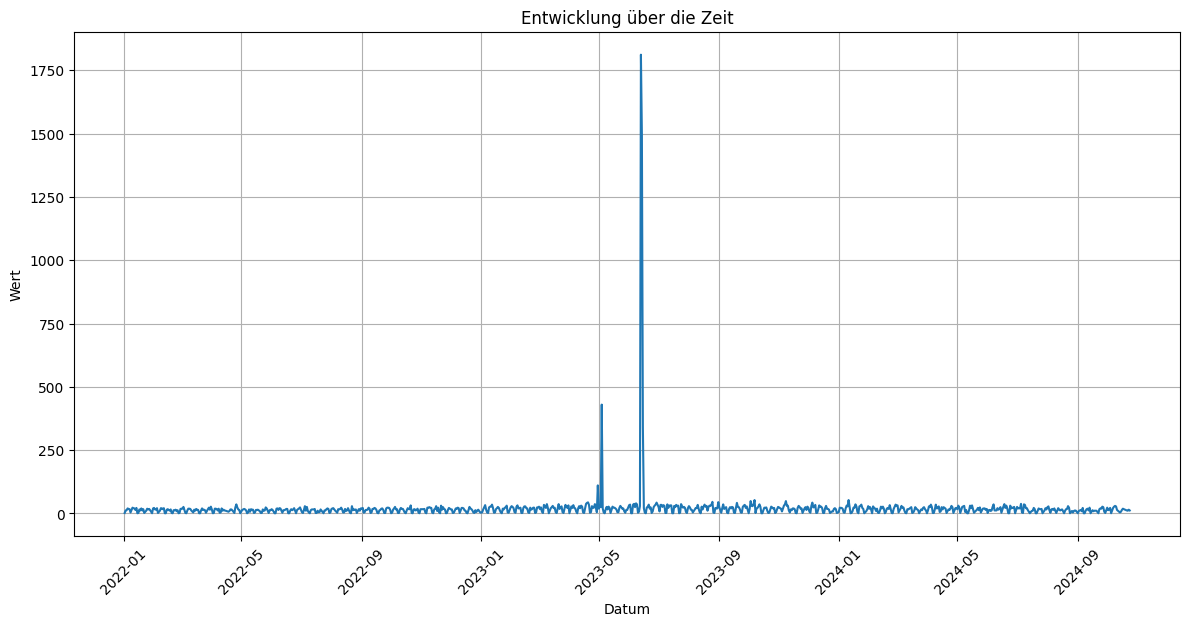

In [21]:
# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(articles_per_date["date"], articles_per_date["count"], linestyle='-')
plt.title("Entwicklung über die Zeit")
plt.xlabel("Datum")
plt.ylabel("Wert")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

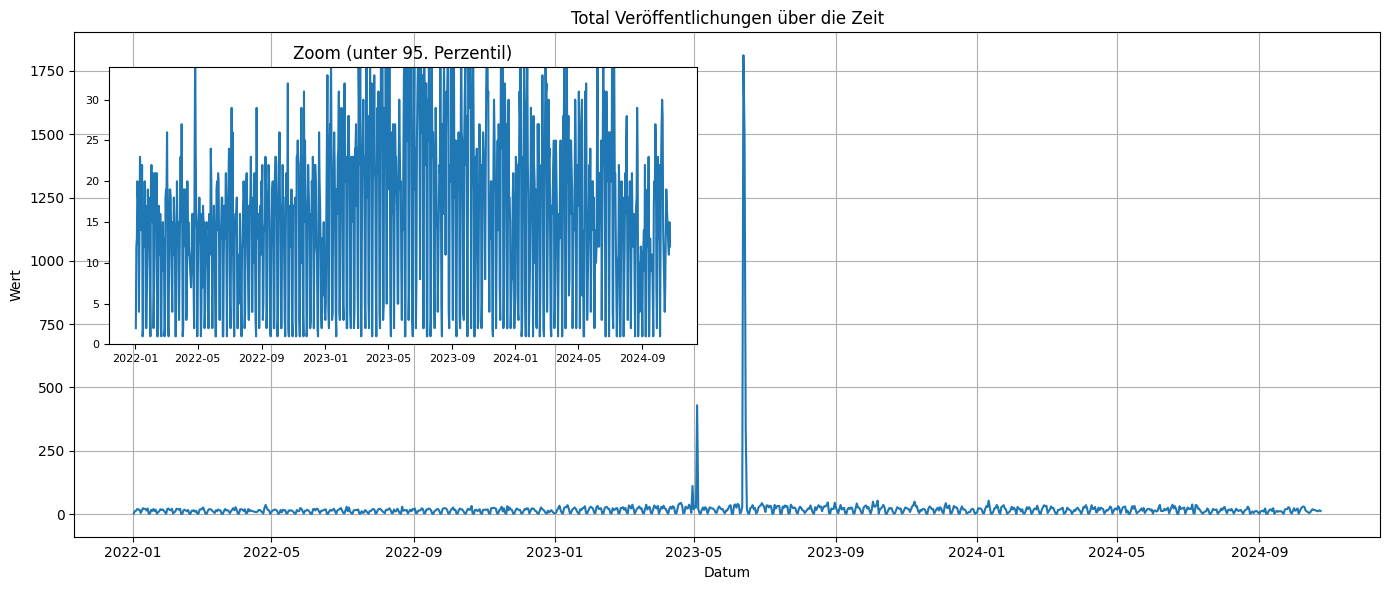

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Hauptplot ---
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(articles_per_date["date"], articles_per_date["count"], label="Count")
ax.set_title("Total Veröffentlichungen über die Zeit")
ax.set_xlabel("Datum")
ax.set_ylabel("Wert")
ax.grid(True)

# --- Inset-Plot (Zoom auf normalen Bereich) ---
axins = inset_axes(ax, width="45%", height="55%", loc="upper left", borderpad=2.5)
axins.plot(articles_per_date["date"], articles_per_date["count"])
axins.set_ylim(0, articles_per_date["count"].quantile(0.95))  # 95%-Perzentil als Cutoff
axins.set_title("Zoom (unter 95. Perzentil)")
axins.tick_params(labelsize=8)



plt.tight_layout()
plt.show()

Es gibt Top 5 Daten, die sich deutlich von den anderen unterscheiden. 2023-06-13 mit 1812, 2023-06-14 mit 1493, 2023-05-04 mit 430, 2023-06-15 mit 340, 2023-04-30 mit 111 Veröffentlichungen. 
Das 95% Perzentil beginnt bei ca. 45 Veröffentlichungen am selben Datum.

#### Anzahl pro Domain zum Datum vom 13.06.2023
Vielleicht können wir herausfinden, warum am 13.06.2023 1812 Artikel veröffentlicht wurden. Dazu werden wir den Datensatz auf das Datum 13.06.2023 filtern, nach Domain filtern und zählen, wieviele Artikel pro Domain veröffentlicht wurden.

In [23]:
article_per_date_and_domain = df_train[df_train["date"] == "2023-06-13"].groupby("domain").size().reset_index(name="count")
article_per_date_and_domain = article_per_date_and_domain.sort_values(by="count", ascending=False)
article_per_date_and_domain.reset_index(drop=True, inplace=True)
article_per_date_and_domain

,domain,count
0,energy-xprt,1760
1,cleantechnica,20
2,decarbxpo,12
3,pv-magazine,8
4,solarpowerworldonline,3
5,azocleantech,3
6,ecofriend,1
7,energyintel,1
8,pv-tech,1
9,solarindustrymag,1


Fast alle Artikel wurden von energy-xprt an diesem Tag veröffentlicht. Wir schauen uns die Titel an

In [24]:
energy_xprt_title_count = df_train[
    (df_train["date"] == "2023-06-13") & (df_train["domain"] == "energy-xprt")
].groupby("title").size().reset_index(name="count")

energy_xprt_title_count = energy_xprt_title_count.sort_values(by="count", ascending=False)
energy_xprt_title_count.reset_index(drop=True, inplace=True)
energy_xprt_title_count

,title,count
0,Energy Storage Companies and Suppliers,6
1,Waste-to-Energy Companies and Suppliers,4
2,Incineration Companies and Suppliers,2
3,lithium-iron phosphate battery ( Battery Energ...,1
4,Airborne Wind Energy - Wind Energy Information,1
...,...,...
1746,power plant equipment ( Energy Management) Tra...,1
1747,power plant finance ( Energy Management) Downl...,1
1748,power stabilization ( Power Distribution) News,1
1749,power stabilization ( Power Distribution) Soft...,1


Aus den Titeln und deren Verteilung ist kein spezieller Grund ersichtlich für die Summe der Artikel an diesem Tag. Wir haben ChatGPT gefragt mit folgendem Prompt: `Gibt es ein spezielles Ereignis am 13.06.2023 im Zusammenhang mit der Domain "energy-xprt"?`

Antwort: `Nach den verfügbaren Informationen gab es am 13. Juni 2023 kein besonderes Ereignis im Zusammenhang mit der Domain "energy-xprt". Energy XPRT ist ein globaler Marktplatz für Lösungen und Anbieter im Energiesektor, der Produktkataloge, Artikel, Branchenveranstaltungen und Publikationen anbietet. citeturn0search0 Obwohl Energy XPRT regelmäßig Veranstaltungen und Neuigkeiten veröffentlicht, scheint an diesem spezifischen Datum kein besonderes Ereignis stattgefunden zu haben. `

Wir nehmen dies so zur Kenntnis.

### Duplikate beim Artikel?

Diese Frage können wir soweit schon beantworten, dass es höchstwahrscheinlich Duplikate gibt, diese aber erst nach der Textbereinigung überprüft werden.

### Welches sind die meist benutzten Worte?

Um den Datensatz inhaltlich bzw. thematisch noch besser kennen zu lernen, möchten wir sehen, welches die häufigsten Wörter sind. Ob das Bereinigen vor einer solchen Analyse sinnvoll ist, versuchen wir herauszufinden. Deshalb suchen wir nach den häufigsten Wörtern vor und nach der Bereinigung, um so den direkten Vergleich zu erhalten.
Wir erstellen zwei Wordclouds.

In [25]:
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from nltk.corpus import stopwords
# languages = ['english', 'german', 'russian', 'spanish']
# stop_words = set()
# for lang in languages:
#     stop_words.update(stopwords.words(lang))

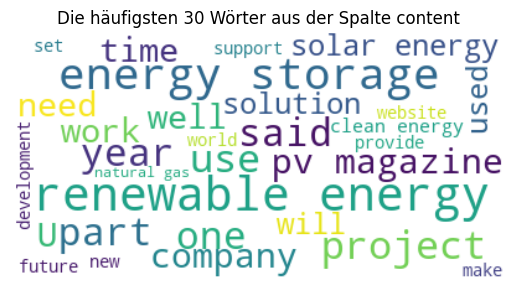

In [ ]:
content = " ".join(df_train["content"].astype(str).tolist())
p.plot_wordcloud(content, c_stopwords=c_stopwords, column_name='content')

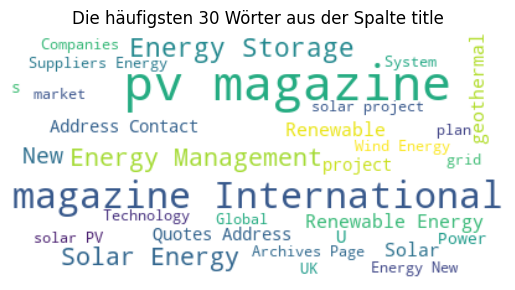

In [27]:
titles = " ".join(df_train["title"].astype(str).tolist())
p.plot_wordcloud(titles, c_stopwords=c_stopwords, column_name='title')

Aus diesen beiden Wordclouds kann man erkennen, dass es vorallem Artikle im Energie-Bereich sind.

### Text Bereinigen


#### Klasse `TextCleaner`
Für die Text Bereinigung haben wir eine Klasse `TextCleaner` erstellt. 
Die Klasse `TextCleaner` ist dafür gedacht, Webtexte oder Textdaten von sogenannter „Boilerplate“ zu bereinigen – das sind Textteile, die keinen inhaltlichen Mehrwert liefern, wie z. B. Cookie-Hinweise, rechtliche Hinweise oder Login-Formulare. Solche Texte stören oft bei der Analyse von Webinhalten, NLP-Projekten oder Textklassifikation. Schauen wir uns die Klasse im Detail an:

🔧 __init__: Konstruktor
Hier werden zwei Dinge initialisiert:

1. boilerplate_patterns: Eine Liste an regulären Ausdrücken (regex), um häufig vorkommende, irrelevante Textbestandteile zu erkennen und zu entfernen (z. B. Cookie-Banner, Captcha, rechtliche Hinweise, Navigation, Newsletter-Aufrufe etc.).

2. end_markers: Stichworte, bei denen davon ausgegangen wird, dass ab diesem Punkt der Text irrelevant ist und abgeschnitten werden kann.

✂️ `truncate_boilerplate_tail(text)`
Schneidet den Text an dem Punkt ab, an dem einer der end_markers auftaucht (z. B. „this content is protected“). Das hilft, um am Ende des Textes automatisch irrelevante Abschnitte zu entfernen.

🧹 `clean_text(text)`
Dies ist die zentrale Methode zur Textbereinigung. Sie macht folgendes:

1. Entfernt URLs mit einem regex.

2. Vereinheitlicht typographische Zeichen (z. B. ersetzt typographische Anführungszeichen durch Standardzeichen).

3. Wendet alle boilerplate_patterns auf den Text an und entfernt sie.

4. Ersetzt Sonderzeichen wie Bindestriche und Unterstriche durch Leerzeichen.

5. Entfernt alle Zeichen außer Buchstaben, Zahlen, Satzzeichen und deutsche Umlaute.

6. Schneidet am Ende des Textes alles ab, was nach einem end_marker kommt (via truncate_boilerplate_tail).

7. Gibt den bereinigten Text zurück.

✅ `is_meaningful(text)`
Prüft, ob der Text nach der Bereinigung überhaupt noch sinnvollen Inhalt hat:

- Ist nicht leer (enthält Buchstaben oder Zahlen).

- Ist nicht nur „Meta-Text“, wie z. B. „NGI“ oder eine ISSN.

So können irrelevante oder leere Texte leicht erkannt und ggf. verworfen werden.

🧾 `clean_text_column(df, column, new_column=None)`
Diese Methode ist gedacht für Pandas DataFrames:

1. Wendet clean_text() auf eine ganze Spalte (column) an.

2. Schreibt die bereinigten Texte entweder in dieselbe oder in eine neue Spalte (new_column).

3. Filtert alle Zeilen raus, deren bereinigter Text nicht sinnvoll ist (is_meaningful).

Um die Funktion des TextCleaners zu überprüfen, verwenden wir den Datenstatz `article_count_per_title`, da dieser die vermuteten doppelten Inhalte aufzeigen kann.

In [28]:
cleaner = TextCleaner()
data_cleaned = cleaner.clean_text_column(article_count_per_title, column="content", new_column="content_cleaned")


In [29]:
data_cleaned_compare = data_cleaned[["content", "content_cleaned"]].copy()
u.styled_text(data_cleaned_compare.head(), max_width=500)

,content,content_cleaned
6940,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...","B.A Hons Comparative Literary Studies, M.A. Moder n Cultures', 'David is an academic researcher and interdisciplinary artist primarily working with te xt, video, sound, and new technologies. His curren t research and practice is focused on the digital ..."
6941,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...","B.A Hons Comparative Literary Studies, M.A. Moder n Cultures', 'David is an academic researcher and interdisciplinary artist primarily working with te xt, video, sound, and new technologies. His curren t research and practice is focused on the digital ..."
6942,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...","B.A Hons Comparative Literary Studies, M.A. Moder n Cultures', 'David is an academic researcher and interdisciplinary artist primarily working with te xt, video, sound, and new technologies. His curren t research and practice is focused on the digital ..."
7110,"[""By clicking `` Allow All '' you agree to the sto ring of cookies on your device to enhance site nav igation, analyse site usage and support us in prov iding free open access scientific content. More in fo."", 'B.A ( Hons) Comparative Literary Studies, M ...","B.A Hons Comparative Literary Studies, M.A. Moder n Cultures', 'David is an academic researcher and interdisciplinary artist primarily working with te xt, video, sound, and new technologies. His curren t research and practice is focused on the digital ..."
13074,"['We use cookies to enhance your experience. By co ntinuing to browse this site you agree to our use of cookies. More info.', 'B.A ( Hons) Comparative Literary Studies, M.A. Modern Cultures', 'David is an academic researcher and interdisciplinary arti ...","B.A Hons Comparative Literary Studies, M.A. Moder n Cultures', 'David is an academic researcher and interdisciplinary artist primarily working with te xt, video, sound, and new technologies. His curren t research and practice is focused on the digital ..."


Nun ist gut zu erkennen, dass es sich höchstwahrscheinlich um dieselben Texte handelt, zumindest sind die ersten 5 Zeilen identisch. Diese Erkenntnis werden wir nutzen, um Duplikate zu entfernen.

### Duplikate entfernen
Bevor die Duplikate entfernt werden können, muss der gesamte Text mit dem TextCleaner bereinigt werden.

#### Gesamten Text bereinigen


In [32]:
df_train_cleaned = cleaner.clean_text_column(df_train, column="content", new_column="content_cleaned")
df_train_cleaned = df_train_cleaned.drop(columns=["content"])

Die Spalte mit den URLs wird mit einer separaten Funktion bereinigt, so dass nur noch die URL ohne Query bestehen bleibt. Dies hilft, Duplikate zu identifizieren.

In [33]:
df_train_cleaned = u.clean_url_column(df_train_cleaned, 'url')

In [35]:
u.styled_text(df_train_cleaned.head(3))

,id,title,date,domain,url,content_cleaned
20107,104264,EDP trials robotic construction on Spanish PV proj ect,2024-10-24 00:00:00,pv-tech,https://www.pv-tech.org/edp-trials-robotic-constru ction-spanish-pv-project/,"Developer EDP is piloting a robotic construction s olution on a 122MW PV power plant in Valladolid, S pain, through which it hopes to significantly cut the project' s build time.', 'The Hyperflex techno logy, developed by Italian robotics specialist Com ..."
20102,101433,"Sunwind Energy’ s new PV planter combines cultivat ion, solar generation – pv magazine International",2024-10-24 00:00:00,pv-magazine,https://www.pv-magazine.com/2024/10/24/sunwind-ene rgys-new-pv-planter-combines-cultivation-solar-gen eration/#respond,"Specializing in the design of custom solar systems , Sunwind Energy will launch the Delta Flore solar PV planter onto the market by the end of the year .', 'The system integrates the planter as ballast, ensuring stability and ease of installation.', 'F ..."
20098,101418,Kaco launches new hybrid inverters for residential applications – pv magazine International,2024-10-23 00:00:00,pv-magazine,https://www.pv-magazine.com/2024/10/23/kaco-launch es-new-hybrid-inverters-for-residential-applicatio ns/,"The German manufacturer unveiled a new line of hyb rid inverters for applications ranging from reside ntial rooftop arrays to projects on small commerci al buildings. They have outputs between 6 kW and 1 2 kW, a maximum efficiency of 98.19, and a maximum ..."


In [36]:
u.styled_text(df_train_cleaned.describe(include=[object]))

,title,domain,url,content_cleaned
count,5254,5254,5254,5254
unique,5234,22,4546,5195
top,Building an Effective Meteorological Station for S olar PV,energy-xprt,https://www.azocleantech.com/news.aspx,Financial assistance programs are deployed by util ities and governments to help grow a renewable ene rgy industry or increase energy efficiency. These programs are justified by a variety of economic an d performance criterias with the objective of tran ...
freq,3,1331,330,6


In [38]:
print(f"Nach dem Bereinigen sind noch {5254} Artikel übrig, was einer Reduktion von {20111 - 5254} Artikeln entspricht.")

Nach dem Bereinigen sind noch 5254 Artikel übrig, was einer Reduktion von 14857 Artikeln entspricht.


### Wordcloud 2.0
Nach der erfolgreichen Bereinigung erstellen wir nochmals dieselben Wordclouds wie zuvor.

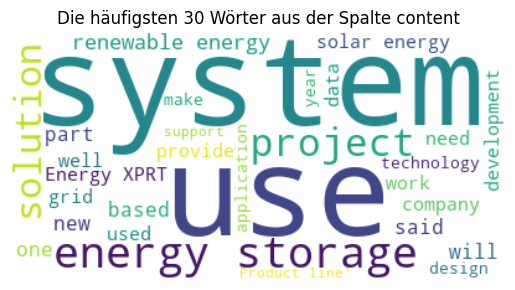

In [43]:
df_train_cleaned.rename(columns={"content_cleaned": "content"}, inplace=True)
content = " ".join(df_train_cleaned["content"].astype(str).tolist())
p.plot_wordcloud(content, c_stopwords=c_stopwords, column_name='content')

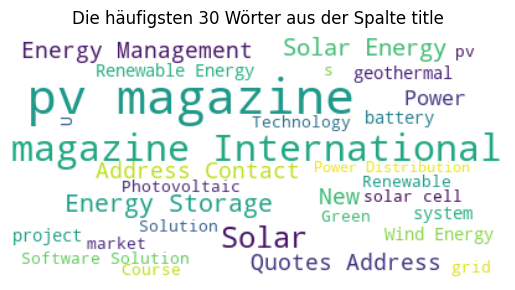

In [44]:
titles = " ".join(df_train_cleaned["title"].astype(str).tolist())
p.plot_wordcloud(titles, c_stopwords=c_stopwords, column_name='title')

Im Vergleich zu den nicht bereinigten Wordclouds kann man nun einen deutlichen Unterschied zwischen Titel und Inhalt erkennen. Vorher war beides sehr ähnlich.
Wenn man die Wordcloud vom Content anschaut, könnte man zum Schluss kommen, dass der Inhalt noch weiter Bereinigt werden sollte, da es nun einige Stopwords anzeigt. Dass bei der zweiten Wordcloud aus Title einzelne Buchstaben angezeigt werden, lässt ebenfalls darauf schliessen, dass noch weiter bereinigt werden sollte.
Zuerst möchten wir aber die wichtigen Wörter mit TF-IDF anschauen und danach beurteilen, wie weiter bereinigt werden sollte.

### wichtige Wörter mit TF-IDF